# Bayesian optimization of electron energy from laser wakefield accelerators [Supplementary material]

P. Valenta,$^{1, *}$ T. Zh. Esirkepov,$^{2}$ J. D. Ludwig,$^{3}$ S. C. Wilks,$^{3}$ and S. V. Bulanov$^{1}$

$^{1}$ ELI Beamlines Facility, The Extreme Light Infrastructure ERIC, Za Radnicí 835, 25241 Dolní Břežany, Czech Republic  
$^{2}$ Kansai Institute for Photon Science, National Institutes for Quantum Science and Technology, Umemidai 8-1-7, Kizugawa, Kyoto 619-0215, Japan  
$^{3}$ Lawrence Livermore National Laboratory, 7000 East Avenue, Livermore, California 94551, USA  

$^{*}$ Electronic mail: petr.valenta@eli-beams.eu

(Dated: 10 September 2025)

## Abstract

We use Bayesian optimization in combination with three-dimensional particle-in-cell simulations to determine the optimal laser and plasma parameters that, for a given laser pulse energy, maximize the cut-off energy of an electron beam produced by laser wakefield accelerators. We assume a Gaussian laser driver with matched spot size and amplitude and investigate both self-guiding in a uniform-density plasma and guiding in a preformed plasma channel with matched radius. To interpret the simulation results quantitatively, we derive novel analytical expressions for the maximum electron energy and the corresponding acceleration distance, accounting for the effects of laser diffraction and energy depletion. Based on the results obtained, we discuss the potential scalability of the optimal input (plasma density, pulse duration, amplitude, spot size, and channel radius) and output (electron energy, electron charge, acceleration length, and acceleration efficiency) parameters to laser systems of arbitrary energy.

---

## Software packages

In [1]:
import sdf
import numpy as np
import scipy as sc
from scipy.constants import elementary_charge as e, m_e, c, pi, epsilon_0 as eps_0
from scipy.signal import savgol_filter
from scipy.io import loadmat
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams["mathtext.fontset"] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import bayes_opt as bo

In [2]:
print("sdf:", sdf.__version__)
print("numpy:", np.__version__)
print("scipy:", sc.__version__)
print("matplotlib:", mpl.__version__)
print("bayesian-optimization:",bo.__version__)

sdf: 2.6.7
numpy: 2.2.4
scipy: 1.15.2
matplotlib: 3.10.0
bayesian-optimization: 1.5.1


## Variables and functions definition

In [3]:
lambda_0 = 1.0e-6
ene_0 = 1.0e-2
omega_0 = 2.0 * pi * c / lambda_0
n_c = m_e * eps_0 * omega_0**2 / e**2
r_e = e**2 / (4.0 * pi * eps_0 * m_e * c**2)
P_bar = 2.0 * m_e * c**3 / r_e
E_bar = pi / omega_0 * P_bar

In [4]:
tau_0 = np.linspace(3.0, 12.0, 1000)
n_e = np.linspace(1.0, 4.0, 1000)
tau_0_, n_e_ = np.meshgrid(tau_0, n_e)
ene_0_ = np.linspace(1.0e-2, 1.0e4, 1000)
tau_0_approx = np.linspace(1.0, 15.0, 1000)
tau_0_approx[np.intersect1d(np.where(tau_0_approx > 10.15), np.where(tau_0_approx < 11.8))] = np.nan
n_e_approx = np.linspace(1.0, 5.0, 1000)
n_e_approx[np.intersect1d(np.where(n_e_approx > 2.5), np.where(n_e_approx < 2.85))] = np.nan

In [5]:
def cmap_t(name, slope):
    cmap = mpl.colormaps.get_cmap(name).copy()
    q = np.linspace(0, cmap.N + 3, cmap.N + 3)
    cmap._init()
    cmap._lut[:,-1] = q / (slope * 259)
    cmap._lut[:,-1][cmap._lut[:,-1] >= 1.0] = 1.0
    cmap.set_bad([0.0, 0.0, 0.0, 0.0])
    return cmap

In [6]:
def spectrum(file):
    try:
        part_px = file.Particles_Px_subset_sub_high_ene_electron.data / (m_e * c)
        part_py = file.Particles_Py_subset_sub_high_ene_electron.data / (m_e * c)
        part_pz = file.Particles_Pz_subset_sub_high_ene_electron.data / (m_e * c)
        part_w = file.Particles_Weight_subset_sub_high_ene_electron.data  
    except AttributeError:
        part_px = np.array([])
        part_py = np.array([])
        part_pz = np.array([])
        part_w = np.array([])
    h = np.zeros((np.size(ene_ax), np.size(theta_ax)), dtype=np.float32)
    ene = (np.sqrt(1.0 + part_px**2 + part_py**2 + part_pz**2) - 1.0) * m_e * c**2 / e * 1.0e-6 # in MeV
    theta = np.arctan(np.sqrt(part_py**2 + part_pz**2) / part_px) # in rad
    w = part_w * e * 1.0e12 # in pC
    h = np.histogram2d(ene, theta, bins=[bins_ene, bins_theta], weights=w)[0] / d_ene / S
    return h

In [7]:
bins_ene, d_ene = np.linspace(0.0, 100.0, 1001, retstep=True)
ene_ax = (bins_ene[1:] + bins_ene[:-1]) / 2.0
bins_theta = np.linspace(0.0, 0.1, 1001)
theta_ax = (bins_theta[1:] + bins_theta[:-1]) / 2.0
S = 2.0 * pi * (np.cos(bins_theta[:-1]) - np.cos(bins_theta[1:]))

## Figure 1(a)

In [8]:
def P_0_over_P_cr(tau_0_, n_e_):
    return 4.84e-26 * (lambda_0**2 * ene_0 * n_e_ * 1.0e25) / (tau_0_ * 1.0e-15)

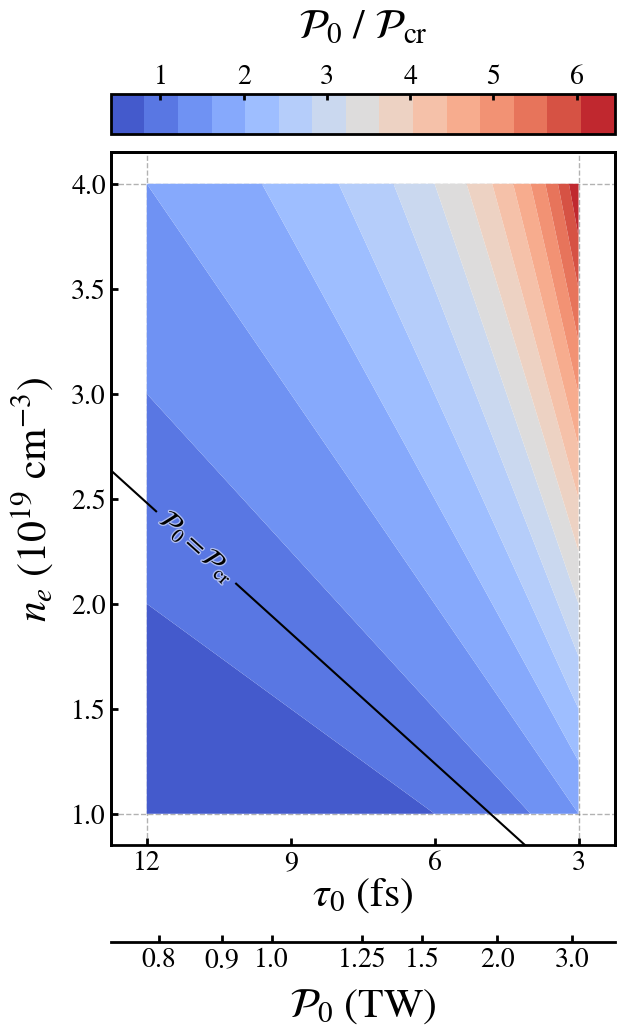

In [9]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 16

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0, n_e, P_0_over_P_cr(tau_0_, n_e_), levels=np.linspace(P_0_over_P_cr(tau_0_, n_e_).min(), P_0_over_P_cr(tau_0_, n_e_).max(), 16), cmap="coolwarm", antialiased=True) # shading="auto", rasterized=True,
ax.plot(tau_0_approx, 1.00 * 2.0672814076016204 * tau_0_approx * 1.0e-15 / (lambda_0**2 * ene_0), color="black", linestyle="-", linewidth=1.5)
ax.annotate(r"$ \mathcal{P}_0 = \mathcal{P}_{\mathrm{cr}}  $", (11.85, 2.1), fontsize=ticklabelsize, color="black", rotation=-42, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ \mathcal{P}_{0} \ / \ \mathcal{P}_{\mathrm{cr}} $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.linspace(1.0, 6.0, 6))

In [10]:
fig.savefig("./fig_1a.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 1(b)

In [11]:
def tau_0_over_tau_r(tau_0_, n_e_):
    return 23.96 * np.sqrt((tau_0_ * 1.0e-15)**2 * (n_e_ * 1.0e25))

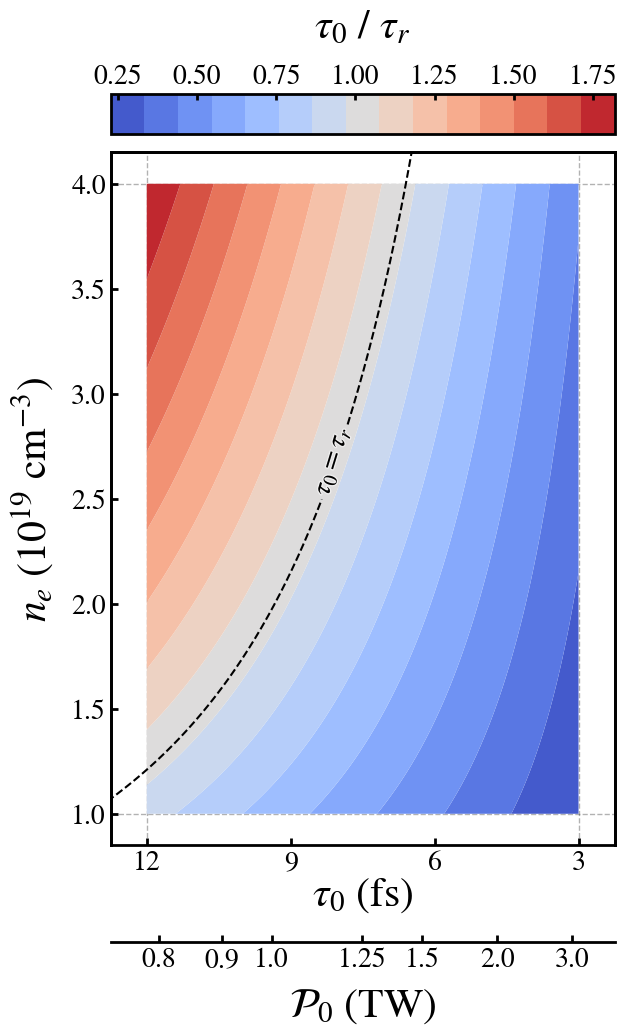

In [12]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 16

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0, n_e, tau_0_over_tau_r(tau_0_, n_e_), levels=np.linspace(tau_0_over_tau_r(tau_0_, n_e_).min(), tau_0_over_tau_r(tau_0_, n_e_).max(), 16), cmap="coolwarm", antialiased=True) # shading="auto", rasterized=True,
ax.plot(1.0 / (23.96 * np.sqrt(n_e_approx * 1.0e25)) * 1.0e15, n_e_approx, color="black", linestyle="--", linewidth=1.5)
ax.annotate(r"$ \tau_0 = \tau_r $", (8.60, 2.53), fontsize=ticklabelsize, color="black", rotation=73, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ \tau_{0} \ / \ \tau_r $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.linspace(0.25, 1.75, 7))

In [13]:
fig.savefig("./fig_1b.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 1(c)

In [14]:
def a_0(tau_0_, n_e_):
    return 7.29e-9 * (lambda_0**2 * ene_0 * n_e_ * 1.0e25 / (tau_0_ * 1.0e-15))**(1.0 / 3.0)

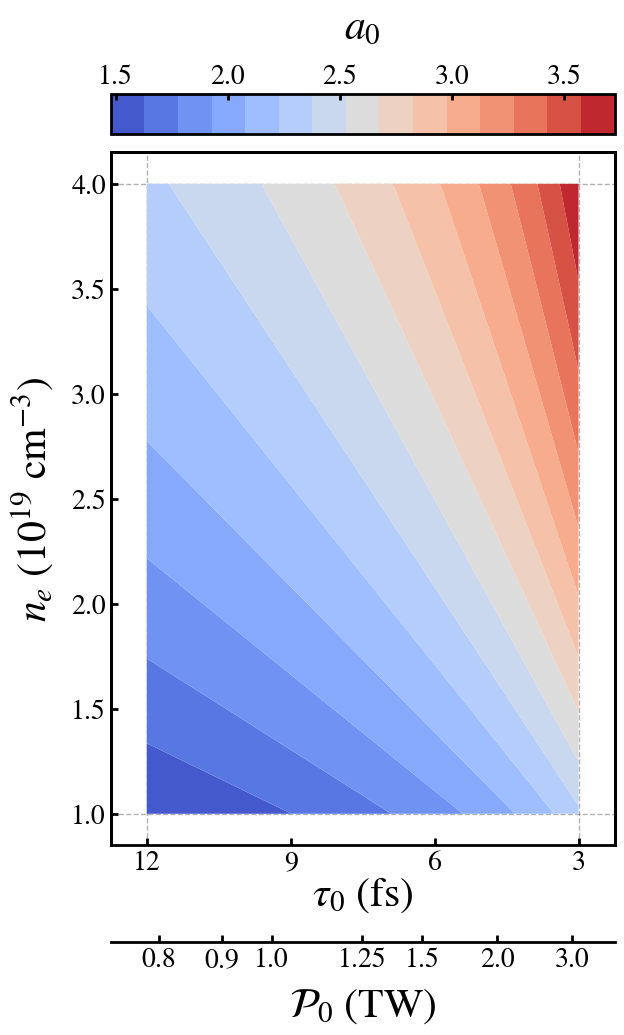

In [15]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 16

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0, n_e, a_0(tau_0_, n_e_), levels=np.linspace(a_0(tau_0_, n_e_).min(), a_0(tau_0_, n_e_).max(), 16), cmap="coolwarm", antialiased=True)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ a_{0} $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.linspace(1.5, 3.5, 5))

In [16]:
fig.savefig("./fig_1c.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 1(d)

In [17]:
def w_0(tau_0_, n_e_):
    return 9.07e2 * (lambda_0**2 * ene_0)**(1.0 / 6.0) / ((n_e_ * 1.0e25)**2 * (tau_0_ * 1.0e-15))**(1.0 / 6.0) / lambda_0

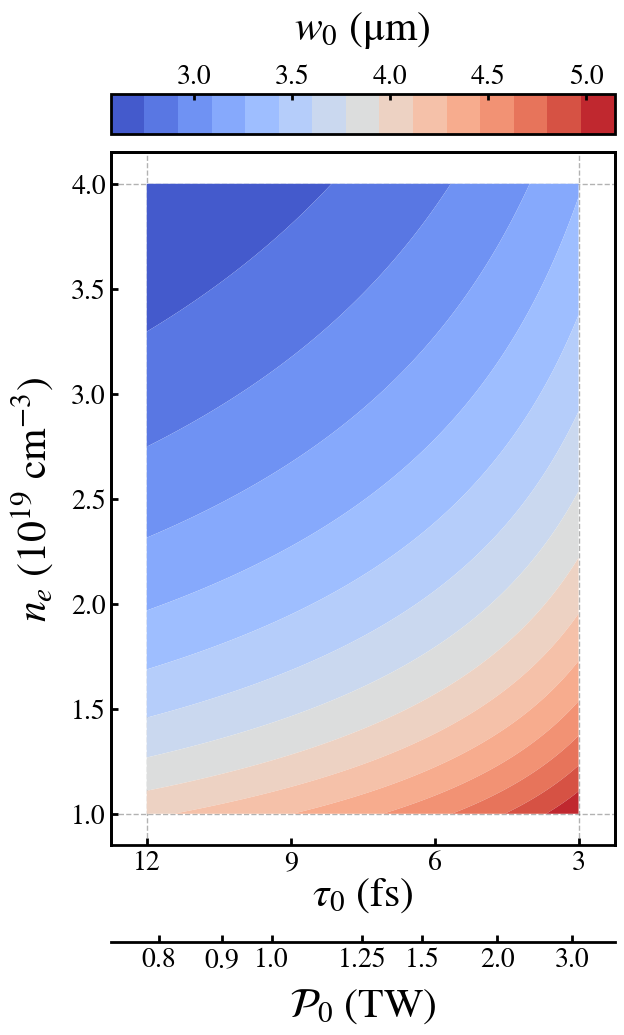

In [18]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 16

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0, n_e, w_0(tau_0_, n_e_), levels=np.linspace(w_0(tau_0_, n_e_).min(), w_0(tau_0_, n_e_).max(), 16), cmap="coolwarm", antialiased=True)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ w_{0} \ (\mathrm{\mu m}) $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.linspace(3.0, 5.0, 5))

In [19]:
fig.savefig("./fig_1d.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 2(a)

In [20]:
pbounds = {"x": (3, 12), "y": (1.0, 4.0)}
optimizer = bo.BayesianOptimization(f=None, pbounds=pbounds)
optimizer.register(params={"x": 8.60, "y": 1.78}, target=32.55) # A1
optimizer.register(params={"x": 6.60, "y": 2.05}, target=39.65) # A2
optimizer.register(params={"x": 9.90, "y": 2.05}, target=33.85) # A3
optimizer.register(params={"x": 7.90, "y": 2.45}, target=50.75) # A4
optimizer.register(params={"x": 7.24, "y": 3.49}, target=66.15) # A5
optimizer.register(params={"x": 6.16, "y": 4.00}, target=57.15) # A6
optimizer.register(params={"x": 3.85, "y": 4.00}, target=54.15) # A7
optimizer.register(params={"x": 3.00, "y": 2.21}, target=38.95) # A8
optimizer.register(params={"x": 8.19, "y": 4.00}, target=55.55) # A9
optimizer.register(params={"x": 12.00, "y": 4.00}, target=40.05) # A10
optimizer.register(params={"x": 12.00, "y": 1.00}, target=17.15) # A11
optimizer.register(params={"x": 4.60, "y": 1.00}, target=22.75) # A12
optimizer.register(params={"x": 7.17, "y": 3.85}, target=57.55) # A13
optimizer.register(params={"x": 7.17, "y": 3.22}, target=65.95) # A14
optimizer.register(params={"x": 7.40, "y": 3.34}, target=65.95) # A15
optimizer.register(params={"x": 6.99, "y": 3.37}, target=67.85) # A16
optimizer.register(params={"x": 6.34, "y": 3.29}, target=63.85) # A17
optimizer.register(params={"x": 6.72, "y": 3.42}, target=63.85) # A18
acq = bo.UtilityFunction(kind="ucb", kappa=5.0)
next_point_to_probe = optimizer.suggest(acq)
x = np.linspace(pbounds["x"][0], pbounds["x"][1], 1000)
y = np.linspace(pbounds["y"][0], pbounds["y"][1], 1000)
xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
Z_est = optimizer._gp.predict(xy).reshape((1000, 1000))

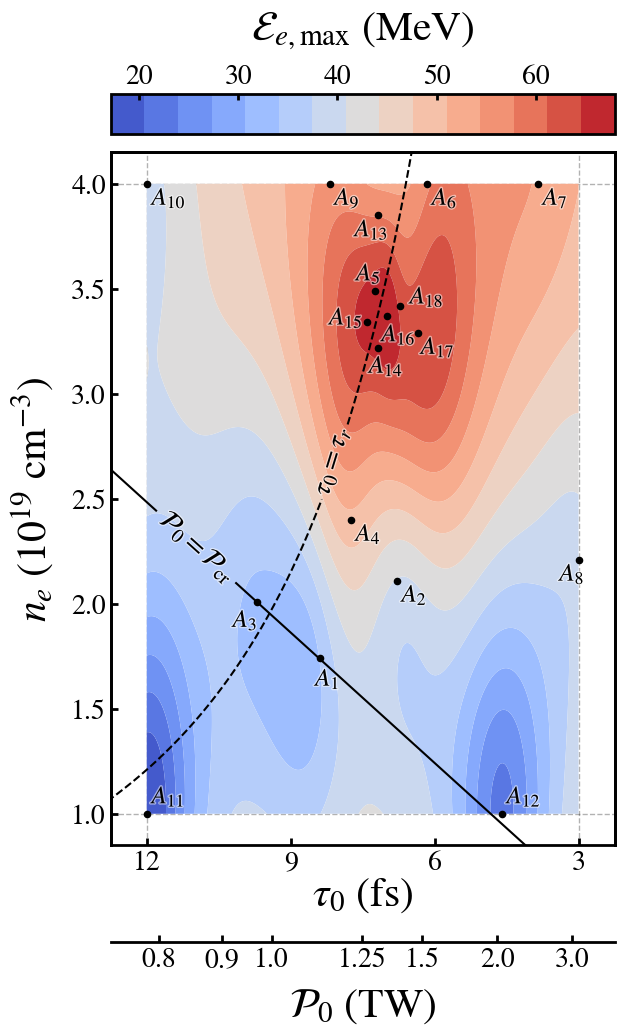

In [21]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 18
pointsize = 20

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(x, y, Z_est, levels=np.linspace(Z_est.min(), Z_est.max(), 16), cmap="coolwarm", antialiased=True)
ax.plot(tau_0_approx, 2.07 * tau_0_approx * 1.0e-15 / (lambda_0**2 * ene_0), color="black", linestyle="-", linewidth=1.5)
ax.annotate(r"$ \mathcal{P}_0 = \mathcal{P}_{\mathrm{cr}}  $", (11.85, 2.10), fontsize=ticklabelsize, color="black", rotation=-42, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.plot(1.0 / (23.96 * np.sqrt(n_e_approx * 1.0e25)) * 1.0e15, n_e_approx, color="black", linestyle="--", linewidth=1.5)
ax.annotate(r"$ \tau_0 = \tau_r $", (8.60, 2.53), fontsize=ticklabelsize, color="black", rotation=73, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70.0))

ax.scatter(8.39, 1.74, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{1} $", (8.49, 1.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.79, 2.11, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{2} $", (6.69, 2.01), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(9.71, 2.01, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{3} $", (10.21, 1.89), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.75, 2.40, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{4} $", (7.65, 2.30), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.24, 3.49, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{5} $", (7.64, 3.54), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.16, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{6} $", (6.06, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(3.85, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{7} $", (3.75, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(3.00, 2.21, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{8} $", (3.40, 2.11), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(8.19, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{9} $", (8.09, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(12.00, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{10} $", (11.90, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(12.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{11} $", (11.90, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(4.60, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{12} $", (4.50, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.17, 3.85, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{13} $", (7.67, 3.75), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.17, 3.22, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{14} $", (7.37, 3.10), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.40, 3.34, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{15} $", (8.20, 3.33), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.99, 3.37, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{16} $", (7.11, 3.25), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.34, 3.29, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{17} $", (6.29, 3.19), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.72, 3.42, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{18} $", (6.52, 3.43), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ \mathcal{E}_{e, \mathrm{max}} \ (\mathrm{MeV}) $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.arange(20, 70, 10))

In [22]:
fig.savefig("./fig_2a.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 2(b)

In [23]:
l_acc_A = loadmat("./A/l_acc_A.mat")["fit"].T

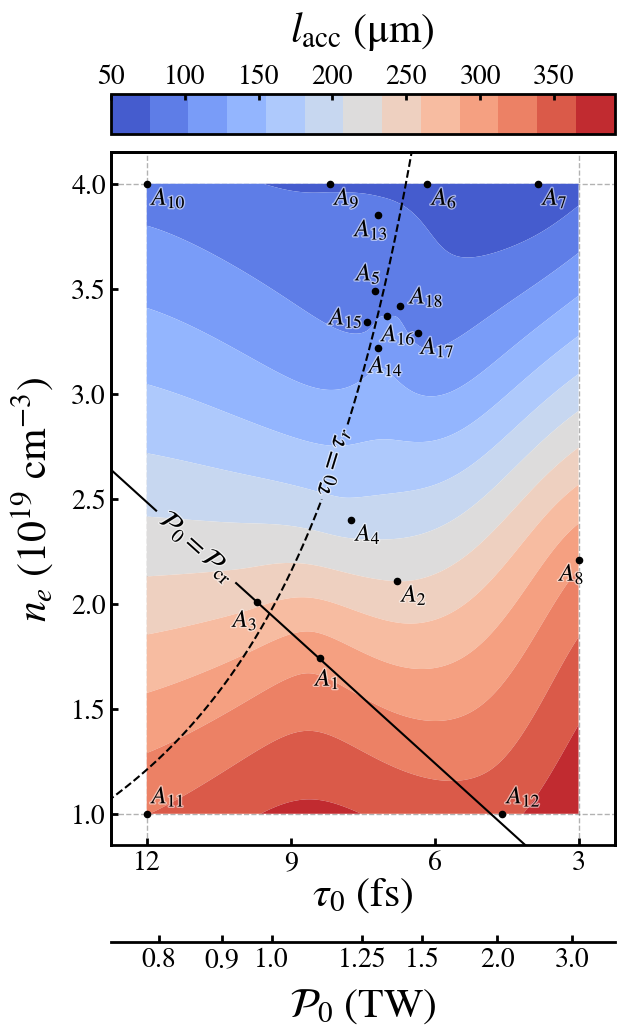

In [24]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 18
pointsize = 20

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0_, n_e_, l_acc_A, levels=np.linspace(l_acc_A.min(), l_acc_A.max(), 14), cmap="coolwarm", antialiased=True)
ax.plot(tau_0_approx, 2.07 * tau_0_approx * 1.0e-15 / (lambda_0**2 * ene_0), color="black", linestyle="-", linewidth=1.5)
ax.annotate(r"$ \mathcal{P}_0 = \mathcal{P}_{\mathrm{cr}}  $", (11.85, 2.1), fontsize=ticklabelsize, color="black", rotation=-42, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.plot(1.0 / (23.96 * np.sqrt(n_e_approx * 1.0e25)) * 1.0e15, n_e_approx, color="black", linestyle="--", linewidth=1.5)
ax.annotate(r"$ \tau_0 = \tau_r $", (8.6, 2.53), fontsize=ticklabelsize, color="black", rotation=73, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

ax.scatter(8.39, 1.74, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{1} $", (8.49, 1.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.79, 2.11, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{2} $", (6.69, 2.01), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(9.71, 2.01, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{3} $", (10.21, 1.89), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.75, 2.40, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{4} $", (7.65, 2.30), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.24, 3.49, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{5} $", (7.64, 3.54), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.16, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{6} $", (6.06, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(3.85, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{7} $", (3.75, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(3.00, 2.21, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{8} $", (3.40, 2.11), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(8.19, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{9} $", (8.09, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(12.00, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{10} $", (11.90, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(12.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{11} $", (11.90, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(4.60, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{12} $", (4.50, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.17, 3.85, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{13} $", (7.67, 3.75), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.17, 3.22, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{14} $", (7.37, 3.10), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.40, 3.34, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{15} $", (8.20, 3.33), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.99, 3.37, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{16} $", (7.11, 3.25), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.34, 3.29, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{17} $", (6.29, 3.19), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.72, 3.42, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ A_{18} $", (6.52, 3.43), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ l_{\mathrm{acc}} \ (\mathrm{\mu m}) $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.arange(50, 400, 50))

In [25]:
fig.savefig("./fig_2b.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 3(b)

In [26]:
file = sdf.read("./A/A_16/high_ene_0066.sdf")
h = spectrum(file)
spec = savgol_filter(np.sum(h * S, axis=1), 11, 0, mode="nearest")
spec[ene_ax < 1.0] = 1.0e-2
div_int = savgol_filter(np.sum(np.abs(h) * d_ene, axis=0), 11, 0, mode="nearest")
div_int[theta_ax > 0.099] = 1.0e0

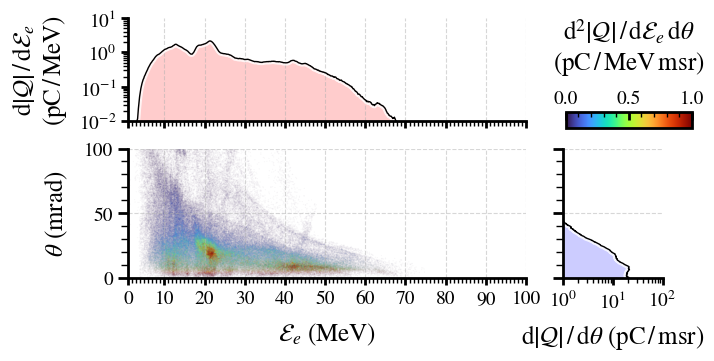

In [27]:
labelsize = 18
ticklabelsize = 14 

fig = plt.figure(figsize=(7, 3.5), constrained_layout=True)
gspec = mpl.gridspec.GridSpec(figure=fig, ncols=3, nrows=2, height_ratios=[1, 1.25], width_ratios=[4, 1, 0.25])

ax_10 = plt.subplot(gspec[1, 0])
im_0 = ax_10.imshow(h.T / 1000, aspect="auto", origin="lower", cmap=cmap_t("turbo", 0.01), extent=[0, 100, 0, 100], interpolation="gaussian", norm=mpl.colors.Normalize(0, 1, clip=True), alpha=1.0)
ax_10.set_xlim(1, 100)
ax_10.set_ylim(0, 100)
ax_10.set_xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_10.set_xticklabels(["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100"])
ax_10.set_xlabel(r"$ \mathcal{E}_e \ \left( \mathrm{MeV} \right) $", fontsize=labelsize, labelpad=10)
ax_10.set_ylabel(r"$ \theta \ \left( \mathrm{mrad} \right) $", fontsize=labelsize, labelpad=10)
ax_10.minorticks_on()
ax_10.xaxis.set_minor_locator(mpl.ticker.FixedLocator([k for k in range(0, 100, 1)]))
ax_10.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="y", which="major", direction="out", length=7.5, width=2.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="y", which="minor", direction="out", length=5.0, width=1.0, labelsize=ticklabelsize)
ax_10.spines["top"].set_visible(False)
ax_10.spines["right"].set_visible(False)
ax_10.grid(axis="both", linestyle="--", alpha=0.5, zorder=1)

ax_00 = plt.subplot(gspec[0, 0])
ax_00.set_yscale("log")
ax_00.plot(ene_ax, spec, color="black", linewidth=1.0, path_effects=[pe.Stroke(linewidth=4.0, alpha=0.8, foreground="white"), pe.Normal()])
ax_00.fill(ene_ax, spec, color="red", alpha=0.2)
ax_00.set_xlim(1.0, 100.0)
ax_00.set_xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_00.set_ylim(1.0e-2, 1.0e1)
ax_00.set_xticklabels([])
ax_00.set_ylabel(r"$ \mathrm{d} \left| \mathcal{Q} \right| \, / \, \mathrm{d} \mathcal{E}_e $" "\n" r"$ \left( \mathrm{pC \, / \, MeV} \right) $", fontsize=labelsize, labelpad=7)
ax_00.minorticks_on()
ax_00.xaxis.set_minor_locator(mpl.ticker.FixedLocator([k for k in range(0, 100, 1)]))
ax_00.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="y", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="y", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_00.spines["right"].set_visible(False)
ax_00.spines["top"].set_visible(False)
ax_00.grid(axis="x", linestyle="--", alpha=0.5, zorder=1)

ax_11 = plt.subplot(gspec[1, 1])
ax_11.set_xscale("log")
ax_11.plot(div_int / 1000, theta_ax * 1000, color="black", linewidth=1.0, path_effects=[pe.Stroke(linewidth=4.0, alpha=0.8, foreground="white"), pe.Normal()])
ax_11.fill_between(div_int / 1000, theta_ax * 1000, facecolor="blue", edgecolor="black", alpha=0.2)
ax_11.set_ylim(0, 100)
ax_11.set_xlim(1e0, 100)
ax_11.set_yticklabels([])
ax_11.set_xlabel(r"$ \mathrm{d} \left| \mathcal{Q} \right| \, / \, \mathrm{d} \theta \ \left( \mathrm{pC \, / \, msr} \right) $", fontsize=labelsize, labelpad=8)
ax_11.minorticks_on()
ax_11.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="y", which="major", direction="out", length=7.5, width=2.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="y", which="minor", direction="out", length=5.0, width=1.0, labelsize=ticklabelsize)
ax_11.spines["right"].set_visible(False)
ax_11.spines["top"].set_visible(False)
ax_11.grid(axis="y", linestyle="--", alpha=0.5, zorder=1)

cbax = fig.add_axes([0.8, 0.65, 0.18, 0.045]) 
cbar = plt.colorbar(im_0, cax=cbax, orientation="horizontal")
cbar.locator = mpl.ticker.MaxNLocator(nbins=4)
cbar.set_label(label=r"$ \mathrm{d}^2 \left| \mathcal{Q} \right| \, / \, \mathrm{d} \mathcal{E}_e \, \mathrm{d} \theta $" "\n" r"$ \left( \mathrm{pC \, / \, MeV \, msr} \right) $", fontsize=labelsize, labelpad=-80)
cbar.ax.minorticks_on()
cbar.ax.tick_params(axis="x", which="major", direction="in", length=6.0, width=2, labelsize=ticklabelsize)
cbar.ax.tick_params(axis="x", which="minor", direction="in", length=3.5, width=1.0, labelsize=ticklabelsize)
cbar.ax.tick_params(axis="y", which="minor", direction="in", length=0.0, width=0.0, labelsize=0.0)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks([0, 0.5, 1])

In [28]:
fig.savefig("./fig_3b.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 4(a)

In [29]:
pbounds = {"x": (3.0, 12.0), "y": (1.0, 4.0)}
optimizer = bo.BayesianOptimization(f=None, pbounds=pbounds, verbose=2, random_state=1)
optimizer.register(params={"x": 8.60, "y": 1.78}, target=60.35) # B1
optimizer.register(params={"x": 6.79, "y": 2.11}, target=67.25) # B2
optimizer.register(params={"x": 9.71, "y": 2.01}, target=55.25) # B3
optimizer.register(params={"x": 7.75, "y": 2.40}, target=61.35) # B4
optimizer.register(params={"x": 5.82, "y": 1.58}, target=64.75) # B5
optimizer.register(params={"x": 5.84, "y": 3.34}, target=66.45) # B6
optimizer.register(params={"x": 3.77, "y": 3.91}, target=50.95) # B7
optimizer.register(params={"x": 12.00, "y": 4.00}, target=43.65) # B8
optimizer.register(params={"x": 3.00, "y": 1.00}, target=57.75) # B9
optimizer.register(params={"x": 12.00, "y": 1.00}, target=62.45) # B10
optimizer.register(params={"x": 7.22, "y": 4.00}, target=60.55) # B11
optimizer.register(params={"x": 7.24, "y": 1.00}, target=62.85) # B12
optimizer.register(params={"x": 6.25, "y": 2.58}, target=86.95) # B13
optimizer.register(params={"x": 5.83, "y": 2.48}, target=80.25) # B14
optimizer.register(params={"x": 6.65, "y": 2.97}, target=80.55) # B15
optimizer.register(params={"x": 6.25, "y": 2.77}, target=88.25) # B16
optimizer.register(params={"x": 6.39, "y": 2.73}, target=92.75) # B17
optimizer.register(params={"x": 6.56, "y": 2.64}, target=88.85) # B18
acq = bo.UtilityFunction(kind="ucb", kappa=5.0)
next_point_to_probe = optimizer.suggest(acq)
x = np.linspace(pbounds["x"][0], pbounds["x"][1], 1000)
y = np.linspace(pbounds["y"][0], pbounds["y"][1], 1000)
xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
Z_est = optimizer._gp.predict(xy).reshape((1000, 1000))

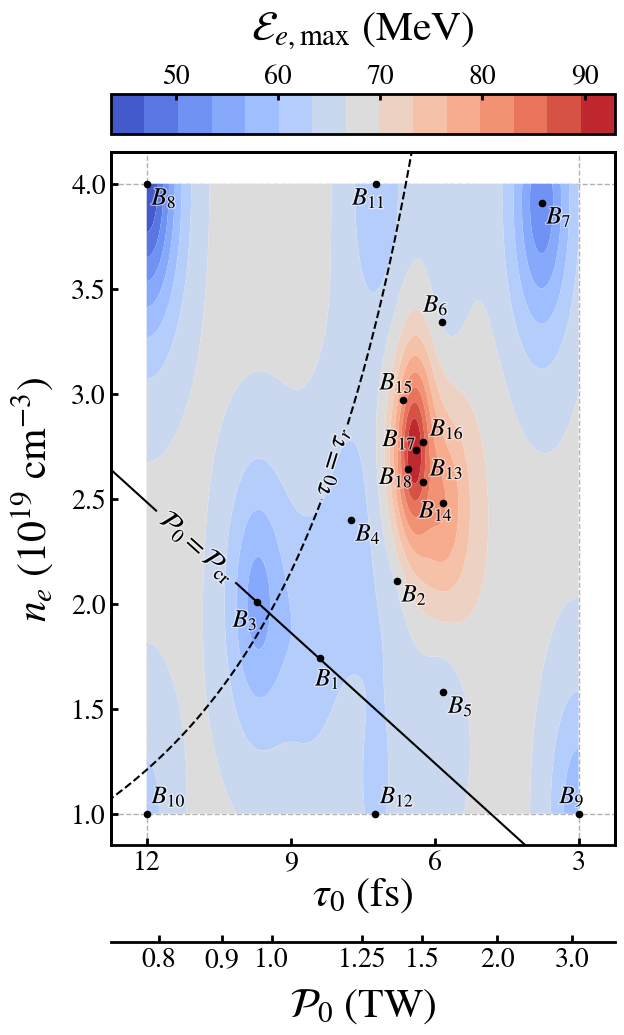

In [30]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 18
pointsize = 20

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(x, y, Z_est, levels=np.linspace(Z_est.min(), Z_est.max(), 16), cmap="coolwarm", antialiased=True)
ax.plot(tau_0_approx, 2.07 * tau_0_approx * 1.0e-15 / (lambda_0**2 * ene_0), color="black", linestyle="-", linewidth=1.5)
ax.annotate(r"$ \mathcal{P}_0 = \mathcal{P}_{\mathrm{cr}}  $", (11.85, 2.1), fontsize=ticklabelsize, color="black", rotation=-42, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.plot(1.0 / (23.96 * np.sqrt(n_e_approx * 1.0e25)) * 1.0e15, n_e_approx, color="black", linestyle="--", linewidth=1.5)
ax.annotate(r"$ \tau_0 = \tau_r $", (8.6, 2.53), fontsize=ticklabelsize, color="black", rotation=73, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

ax.scatter(8.39, 1.74, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_1 $", (8.49, 1.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.79, 2.11, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_2 $", (6.69, 2.01), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(9.71, 2.01, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_3 $", (10.21, 1.89), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.75, 2.40, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_4 $", (7.65, 2.30), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(5.82, 1.58, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_5 $", (5.72, 1.48), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(5.84, 3.34, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_6 $", (6.24, 3.39), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(3.77, 3.91, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_7 $", (3.67, 3.81), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(12.00, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_8 $", (11.90, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(3.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_9 $", (3.40, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(12.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{10} $", (11.90, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(7.22, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{11} $", (7.72, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(7.24, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{12} $", (7.14, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.25, 2.58, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{13} $", (6.10, 2.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(5.83, 2.48, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{14} $", (6.33, 2.41), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.65, 2.97, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{15} $", (7.15, 3.02), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.25, 2.77, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{16} $", (6.10, 2.80), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.39, 2.73, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{17} $", (7.09, 2.75), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.56, 2.64, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{18} $", (7.16, 2.57), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ \mathcal{E}_{e, \mathrm{max}} \ (\mathrm{MeV}) $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.arange(50, 100, 10))

In [31]:
fig.savefig("./fig_4a.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 4(b)

In [32]:
l_acc_B = loadmat("./B/l_acc_B.mat")["fit"].T

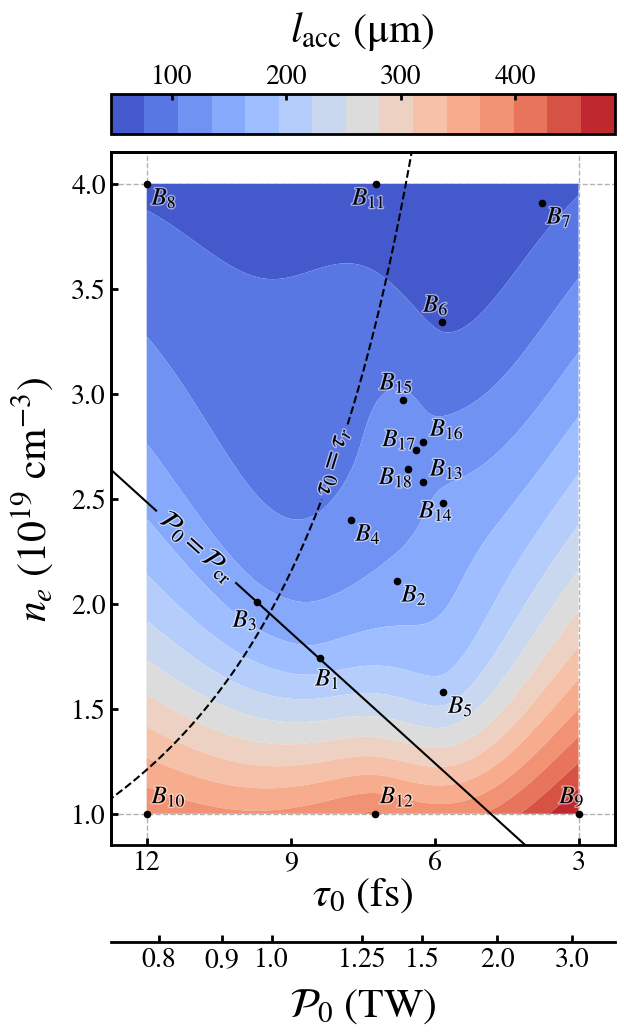

In [33]:
textalpha = 0.5
labelsize = 30
ticklabelsize = 20
annotationsize = 18
pointsize = 20

fig, ax = plt.subplots(figsize=(6.5, 9.0), frameon=True)
ax.invert_xaxis()

im_1 = ax.contourf(tau_0_, n_e_, l_acc_B, levels=np.linspace(l_acc_B.min(), l_acc_B.max(), 16), cmap="coolwarm", antialiased=True)
ax.plot(tau_0_approx, 2.07 * tau_0_approx * 1.0e-15 / (lambda_0**2 * ene_0), color="black", linestyle="-", linewidth=1.5)
ax.annotate(r"$ \mathcal{P}_0 = \mathcal{P}_{\mathrm{cr}}  $", (11.85, 2.1), fontsize=ticklabelsize, color="black", rotation=-42, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.plot(1.0 / (23.96 * np.sqrt(n_e_approx * 1.0e25)) * 1.0e15, n_e_approx, color="black", linestyle="--", linewidth=1.5)
ax.annotate(r"$ \tau_0 = \tau_r $", (8.6, 2.53), fontsize=ticklabelsize, color="black", rotation=73, path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)
ax.set_xlim(12.75, 2.25)
ax.set_ylim(0.85, 4.15)
ax.set_xticks([3, 6, 9, 12])
ax.set_xlabel(r"$ \tau_0 \ (\mathrm{fs}) $", fontsize=labelsize, labelpad=0)
ax.set_ylabel(r"$ n_e \ (10^{19} \ \mathrm{cm^{-3}}) $", fontsize=labelsize, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax.axvline(3.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axvline(12.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)
ax.axhline(4.0, color="black", linewidth=1.0, linestyle="--", alpha=0.3, zorder=0)

ax_b = ax.twiny()
ax_b.set_xlim(12.75, 2.25)
ax_b.set_xlabel(r"$ \mathcal{P}_0 \ (\mathrm{TW}) $", fontsize=labelsize, labelpad=10)
ax_b.set_xticks(2.0 * np.sqrt(np.log(2.0) / pi) * ene_0 / np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0]) / 1.0e-3)
ax_b.set_xticklabels([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0])
ax_b.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_b.tick_params(axis="both", which="minor", direction="in", length=0.0, width=0.0, labelsize=ticklabelsize)
ax_b.set_frame_on(True)
ax_b.patch.set_visible(False)
ax_b.xaxis.set_ticks_position("bottom")
ax_b.xaxis.set_label_position("bottom")
ax_b.spines["bottom"].set_position(("outward", 70))

ax.scatter(8.39, 1.74, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_1 $", (8.49, 1.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(6.79, 2.11, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_2 $", (6.69, 2.01), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(9.71, 2.01, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_3 $", (10.21, 1.89), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(7.75, 2.40, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_4 $", (7.65, 2.30), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2, alpha=textalpha, foreground="white"), pe.Normal()], zorder=10)

ax.scatter(5.82, 1.58, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_5 $", (5.72, 1.48), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(5.84, 3.34, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_6 $", (6.24, 3.39), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(3.77, 3.91, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_7 $", (3.67, 3.81), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(12.00, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_8 $", (11.90, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(3.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_9 $", (3.40, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(12.00, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{10} $", (11.90, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(7.22, 4.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{11} $", (7.72, 3.90), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(7.24, 1.00, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{12} $", (7.14, 1.05), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.25, 2.58, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{13} $", (6.10, 2.61), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(5.83, 2.48, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{14} $", (6.33, 2.41), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.65, 2.97, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{15} $", (7.15, 3.02), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.25, 2.77, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{16} $", (6.10, 2.80), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.39, 2.73, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{17} $", (7.09, 2.75), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

ax.scatter(6.56, 2.64, s=pointsize, marker="o", color="black", zorder=10)
ax.annotate(r"$ B_{18} $", (7.16, 2.57), fontsize=annotationsize, color="black", path_effects=[pe.Stroke(linewidth=2.0, alpha=textalpha, foreground="white"), pe.Normal()])

cbax = fig.add_axes([0.125, 0.9, 0.775, 0.045]) 
cbar = plt.colorbar(im_1, cax=cbax, orientation="horizontal")
cbar.set_label(label=r"$ l_{\mathrm{acc}} \ (\mathrm{\mu m}) $", fontsize=labelsize, labelpad=-90)
cbar.ax.tick_params(axis="x", which="major", direction="in", length=4.0, width=2.0, labelsize=ticklabelsize)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks(np.linspace(100, 400, 4))

In [34]:
fig.savefig("./fig_4b.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 5(b)

In [35]:
file = sdf.read("./B/B_17/high_ene_0075.sdf")
h = spectrum(file)
spec = savgol_filter(np.sum(h * S, axis=1), 11, 0, mode="nearest")
spec[ene_ax < 1.0] = 1.0e-2
div_int = savgol_filter(np.sum(np.abs(h) * d_ene, axis=0), 11, 0, mode="nearest")
div_int[theta_ax > 0.099] = 1.0e0

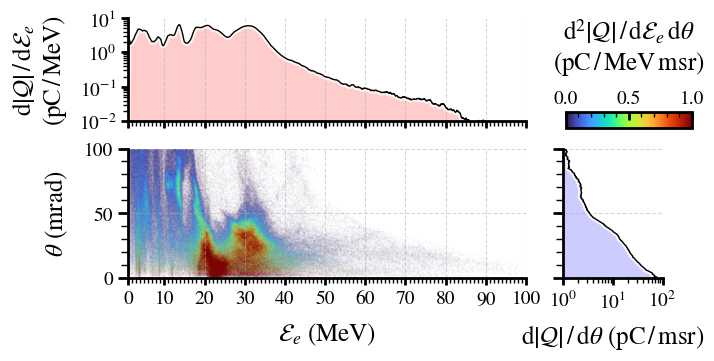

In [36]:
labelsize = 18
ticklabelsize = 14 

fig = plt.figure(figsize=(7, 3.5), constrained_layout=True)
gspec = mpl.gridspec.GridSpec(figure=fig, ncols=3, nrows=2, height_ratios=[1, 1.25], width_ratios=[4, 1, 0.25])

ax_10 = plt.subplot(gspec[1, 0])
im_0 = ax_10.imshow(h.T / 1000, aspect="auto", origin="lower", cmap=cmap_t("turbo", 0.01), extent=[0, 100, 0, 100], interpolation="gaussian", norm=mpl.colors.Normalize(0, 1, clip=True), alpha=1.0)
ax_10.set_xlim(1, 100)
ax_10.set_ylim(0, 100)
ax_10.set_xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_10.set_xticklabels(["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100"])
ax_10.set_xlabel(r"$ \mathcal{E}_e \ \left( \mathrm{MeV} \right) $", fontsize=labelsize, labelpad=10)
ax_10.set_ylabel(r"$ \theta \ \left( \mathrm{mrad} \right) $", fontsize=labelsize, labelpad=10)
ax_10.minorticks_on()
ax_10.xaxis.set_minor_locator(mpl.ticker.FixedLocator([k for k in range(0, 100, 1)]))
ax_10.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="y", which="major", direction="out", length=7.5, width=2.0, labelsize=ticklabelsize)
ax_10.tick_params(axis="y", which="minor", direction="out", length=5.0, width=1.0, labelsize=ticklabelsize)
ax_10.spines["top"].set_visible(False)
ax_10.spines["right"].set_visible(False)
ax_10.grid(axis="both", linestyle="--", alpha=0.5, zorder=1)

ax_00 = plt.subplot(gspec[0, 0])
ax_00.set_yscale("log")
ax_00.plot(ene_ax, spec, color="black", linewidth=1.0, path_effects=[pe.Stroke(linewidth=4.0, alpha=0.8, foreground="white"), pe.Normal()])
ax_00.fill(ene_ax, spec, color="red", alpha=0.2)
ax_00.set_xlim(1.0, 100.0)
ax_00.set_xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_00.set_ylim(1.0e-2, 1.0e1)
ax_00.set_xticklabels([])
ax_00.set_ylabel(r"$ \mathrm{d} \left| \mathcal{Q} \right| \, / \, \mathrm{d} \mathcal{E}_e $" "\n" r"$ \left( \mathrm{pC \, / \, MeV} \right) $", fontsize=labelsize, labelpad=7)
ax_00.minorticks_on()
ax_00.xaxis.set_minor_locator(mpl.ticker.FixedLocator([k for k in range(0, 100, 1)]))
ax_00.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="y", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_00.tick_params(axis="y", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_00.spines["right"].set_visible(False)
ax_00.spines["top"].set_visible(False)
ax_00.grid(axis="x", linestyle="--", alpha=0.5, zorder=1)

ax_11 = plt.subplot(gspec[1, 1])
ax_11.set_xscale("log")
ax_11.plot(div_int / 1000, theta_ax * 1000, color="black", linewidth=1.0, path_effects=[pe.Stroke(linewidth=4.0, alpha=0.8, foreground="white"), pe.Normal()])
ax_11.fill_between(div_int / 1000, theta_ax * 1000, facecolor="blue", edgecolor="black", alpha=0.2)
ax_11.set_ylim(0, 100)
ax_11.set_xlim(1e0, 100)
ax_11.set_yticklabels([])
ax_11.set_xlabel(r"$ \mathrm{d} \left| \mathcal{Q} \right| \, / \, \mathrm{d} \theta \ \left( \mathrm{pC \, / \, msr} \right) $", fontsize=labelsize, labelpad=8)
ax_11.minorticks_on()
ax_11.tick_params(axis="x", which="major", direction="out", length=5.0, width=2.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="x", which="minor", direction="out", length=3.5, width=1.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="y", which="major", direction="out", length=7.5, width=2.0, labelsize=ticklabelsize)
ax_11.tick_params(axis="y", which="minor", direction="out", length=5.0, width=1.0, labelsize=ticklabelsize)
ax_11.spines["right"].set_visible(False)
ax_11.spines["top"].set_visible(False)
ax_11.grid(axis="y", linestyle="--", alpha=0.5, zorder=1)

cbax = fig.add_axes([0.8, 0.65, 0.18, 0.045]) 
cbar = plt.colorbar(im_0, cax=cbax, orientation="horizontal")
cbar.locator = mpl.ticker.MaxNLocator(nbins=4)
cbar.set_label(label=r"$ \mathrm{d}^2 \left| \mathcal{Q} \right| \, / \, \mathrm{d} \mathcal{E}_e \, \mathrm{d} \theta $" "\n" r"$ \left( \mathrm{pC \, / \, MeV \, msr} \right) $", fontsize=labelsize, labelpad=-80)
cbar.ax.minorticks_on()
cbar.ax.tick_params(axis="x", which="major", direction="in", length=6.0, width=2, labelsize=ticklabelsize)
cbar.ax.tick_params(axis="x", which="minor", direction="in", length=3.5, width=1.0, labelsize=ticklabelsize)
cbar.ax.tick_params(axis="y", which="minor", direction="in", length=0.0, width=0.0, labelsize=0.0)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_ticks([0, 0.5, 1])

In [37]:
fig.savefig("./fig_5b.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)

## Figure 6

In [38]:
P_star_A = 2.31
P_star_B = 2.06

tau_star_A = 2.28
tau_star_B = 1.88

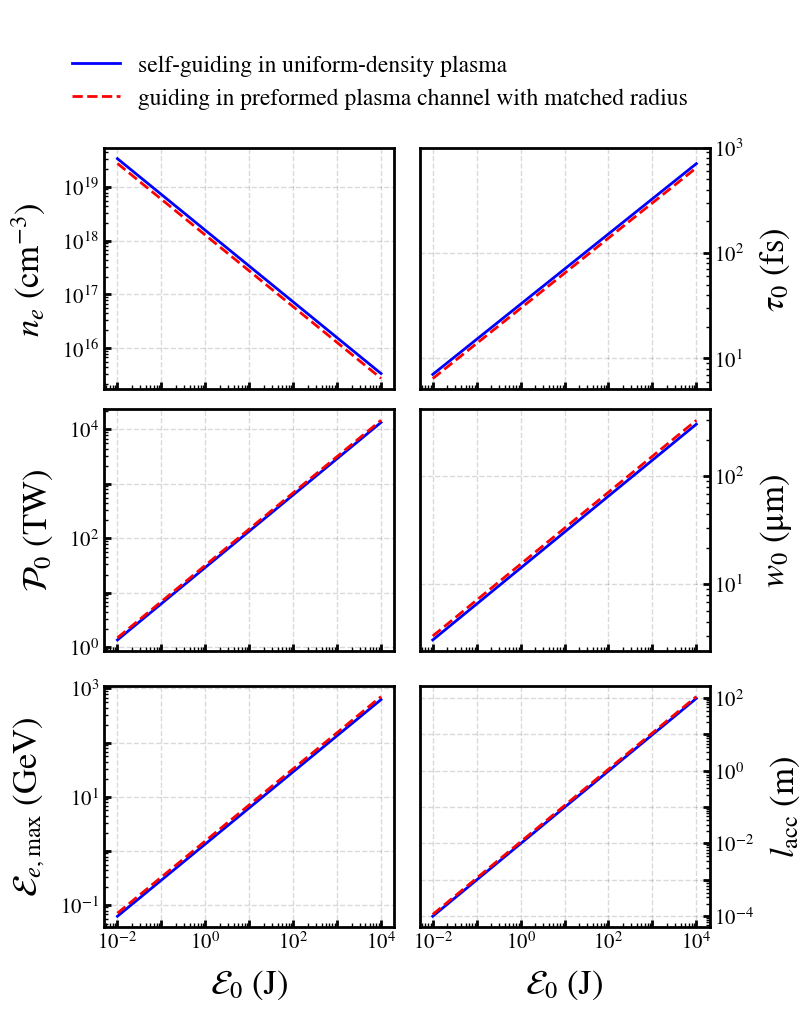

In [39]:
labelsize = 25
ticksize = 15
annotationsize = 15

fig = plt.figure(figsize=(8, 10), constrained_layout=True)
gspec = mpl.gridspec.GridSpec(figure=fig, ncols=2, nrows=4, width_ratios=[1.0, 1.0], height_ratios=[0.1, 1.0, 1.0, 1.0], wspace=0.0, hspace=0.08)

ax_00 = plt.subplot(gspec[1, 0])
ax_00.plot(ene_0_, 0.49 * (P_star_A)**(2/3) * (tau_star_A)**(2/3) * (ene_0_ / E_bar)**(-2.0 / 3.0) * n_c / 1.0e6, linewidth=2.0, color="blue", label="self-guiding in uniform-density plasma")
ax_00.plot(ene_0_, 0.49 * (P_star_B)**(2/3) * (tau_star_B)**(2/3) * (ene_0_ / E_bar)**(-2.0 / 3.0) * n_c / 1.0e6, linewidth=2.0, linestyle="--", color="red", label="guiding in preformed plasma channel with matched radius")
ax_00.set_xscale("log")
ax_00.set_yscale("log")
ax_00.set_ylabel(r"$ n_{e} \ \left( \mathrm{cm^{-3}} \right) $", fontsize=labelsize, labelpad=10)
ax_00.set_xticks(np.logspace(-2, 4, 7))
ax_00.set_xticklabels([])
ax_00.set_yticks(np.logspace(16, 19, 4))
ax_00.minorticks_on()
ax_00.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_00.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_00.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_00.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_00.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_00.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_00.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

ax_01 = plt.subplot(gspec[1, 1])
ax_01.plot(ene_0_, 0.23 * (P_star_A)**(-1/3) * (tau_star_A)**(2/3) * (ene_0_ / E_bar)**(1.0 / 3.0) * (lambda_0 / c) / 1.0e-15, linewidth=2.0, color="blue")
ax_01.plot(ene_0_, 0.23 * (P_star_B)**(-1/3) * (tau_star_B)**(2/3) * (ene_0_ / E_bar)**(1.0 / 3.0) * (lambda_0 / c) / 1.0e-15, linewidth=2.0, linestyle="--", color="red")
ax_01.set_xscale("log")
ax_01.set_yscale("log")
ax_01.set_ylabel(r"$ \tau_{0} \ \left( \mathrm{fs} \right) $", fontsize=labelsize, labelpad=10)
ax_01.set_xticks(np.logspace(-2, 4, 7))
ax_01.set_xticklabels([])
ax_01.set_yticks(np.logspace(1, 3, 3))
ax_01.yaxis.tick_right()
ax_01.yaxis.set_label_position("right")
ax_01.minorticks_on()
ax_01.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_01.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_01.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_01.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_01.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

ax_10 = plt.subplot(gspec[2, 0])
ax_10.plot(ene_0_, 2.06 * P_bar * (P_star_A)**(1/3) * (tau_star_A)**(-2/3) * (ene_0_ / E_bar)**(2.0 / 3.0) / 1e12, linewidth=2.0, color="blue")
ax_10.plot(ene_0_, 2.06 * P_bar * (P_star_B)**(1/3) * (tau_star_B)**(-2/3) * (ene_0_ / E_bar)**(2.0 / 3.0) / 1e12, linewidth=2.0, linestyle="--", color="red")
ax_10.set_xscale("log")
ax_10.set_yscale("log")
ax_10.set_ylabel(r"$ \mathcal{P}_{0} \ \left( \mathrm{TW} \right) $", fontsize=labelsize, labelpad=10)
ax_10.set_xticks(np.logspace(-2, 4, 7))
ax_10.set_xticklabels([])
ax_10.set_yticks(np.logspace(0, 4, 5))
ax_10.set_yticklabels([r"$ 10^{0} $", "", r"$ 10^{2} $", "", r"$ 10^{4} $"])
ax_10.minorticks_on()
ax_10.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_10.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_10.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_10.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_10.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_10.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_10.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

ax_11 = plt.subplot(gspec[2, 1])
ax_11.plot(ene_0_, 0.65 * (P_star_A)**(-1/6) * (tau_star_A)**(-1/3) * (ene_0_ / E_bar)**(1.0 / 3.0), linewidth=2.0, color="blue")
ax_11.plot(ene_0_, 0.65 * (P_star_B)**(-1/6) * (tau_star_B)**(-1/3) * (ene_0_ / E_bar)**(1.0 / 3.0), linewidth=2.0, linestyle="--", color="red")
ax_11.set_xscale("log")
ax_11.set_yscale("log")
ax_11.set_ylabel(r"$ w_{0} \ \left( \mathrm{\mu m} \right) $", fontsize=labelsize, labelpad=10)
ax_11.set_xticks(np.logspace(-2, 4, 7))
ax_11.set_xticklabels([])
ax_11.yaxis.tick_right()
ax_11.yaxis.set_label_position("right")
ax_11.minorticks_on()
ax_11.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_11.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_11.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_11.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_11.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_11.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_11.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

ax_20 = plt.subplot(gspec[3, 0])
ax_20.plot(ene_0_, 4.28 * (tau_star_A)**(-2/3) * (ene_0_ / E_bar)**(2.0 / 3.0) * (m_e * c**2 / e) / 1.0e9, linewidth=2.0, color="blue")
ax_20.plot(ene_0_, 4.28 * (tau_star_B)**(-2/3) * (ene_0_ / E_bar)**(2.0 / 3.0) * (m_e * c**2 / e) / 1.0e9, linewidth=2.0, linestyle="--", color="red")
ax_20.set_xscale("log")
ax_20.set_yscale("log")
ax_20.set_xlabel(r"$ \mathcal{E}_0 \ \left( \mathrm{J} \right) $", fontsize=labelsize, labelpad=10)
ax_20.set_ylabel(r"$ \mathcal{E}_{e, \mathrm{max}} \ \left( \mathrm{GeV} \right) $", fontsize=labelsize, labelpad=10)
ax_20.set_xticks(np.logspace(-2, 4, 7))
ax_20.set_xticklabels([r"$ 10^{-2} $", "", r"$ 10^{0} $", "", r"$ 10^{2} $", "", r"$ 10^{4} $"])
ax_20.set_yticks(np.logspace(-1, 3, 5))
ax_20.set_yticklabels([r"$ 10^{-1} $", "", r"$ 10^{1} $", "", r"$ 10^{3} $"])
ax_20.minorticks_on()
ax_20.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_20.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_20.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_20.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_20.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_20.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_20.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

ax_21 = plt.subplot(gspec[3, 1])
ax_21.plot(ene_0_, 0.66 * (P_star_A)**(-1) * (ene_0_ / E_bar) * lambda_0, linewidth=2.0, color="blue")
ax_21.plot(ene_0_, 0.66 * (P_star_B)**(-1) * (ene_0_ / E_bar) * lambda_0, linewidth=2.0, linestyle="--", color="red")
ax_21.set_xscale("log")
ax_21.set_yscale("log")
ax_21.set_xlabel(r"$ \mathcal{E}_0 \ \left( \mathrm{J} \right) $", fontsize=labelsize, labelpad=10)
ax_21.set_ylabel(r"$ l_{\mathrm{acc}} \ \left( \mathrm{m} \right) $", fontsize=labelsize, labelpad=10)
ax_21.set_xticks(np.logspace(-2, 4, 7))
ax_21.set_xticklabels([r"$ 10^{-2} $", "", r"$ 10^{0} $", "", r"$ 10^{2} $", "", r"$ 10^{4} $"])
ax_21.set_yticks(np.logspace(-4, 2, 7))
ax_21.set_yticklabels([r"$ 10^{-4} $", "", r"$ 10^{-2} $", "", r"$ 10^{0} $", "", r"$ 10^{2} $"])
ax_21.yaxis.tick_right()
ax_21.yaxis.set_label_position("right")
ax_21.minorticks_on()
ax_21.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_21.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_21.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 8), numticks=8))
ax_21.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_21.tick_params(axis="both", which="major", direction="in", length=5.0, width=2.0, labelsize=ticksize)
ax_21.tick_params(axis="both", which="minor", direction="in", length=3.0, width=1.0, labelsize=ticksize)
ax_21.grid(axis="both", color="black", linewidth=1.0, linestyle="--", alpha=0.15)

h, l = ax_00.get_legend_handles_labels()
ax_3 = plt.subplot(gspec[0, :])
ax_3.axis("off")
ax_3.legend(h, l, bbox_to_anchor=(1.0, 0), frameon=False, fontsize=annotationsize+2)

In [40]:
fig.savefig("./fig_6.svg", dpi=300, bbox_inches="tight", facecolor="white", transparent=False)